In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import sys
plt.style.use("dark_background") 
sys.path.append("../src/inference")
from score_models import ScoreModel
from posterior_sampling import euler_sampler, pc_sampler
from forward_model import ftshift, complex_to_real, score_likelihood, model
# from posterior_sampling import euler_sampler, complex_to_real, real_to_complex, sigma, mu
# from forward_model import ft, ift, model, score_likelihood, link_function, noise_padding
torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
score_model = ScoreModel(checkpoints_directory="/home/noedia/projects/rrg-lplevass/data/score_models/ncsnpp_vp_skirt_z_256_230813225243/")

Using the Variance Preserving SDE


In [2]:
pixel_scale = 0.0015
img_size = 256
npix = 4096
pad = (npix-img_size)//2

# Importing data
with np.load("/home/noedia/projects/rrg-lplevass/data/htlup_4096_gridded_sinc.npz") as data_gridded: 
        vis_bin_re = torch.tensor(data_gridded["vis_bin_re"]).to(device)
        vis_bin_imag = torch.tensor(data_gridded["vis_bin_imag"]).to(device)
        std_bin_re = torch.tensor(data_gridded["std_bin_re"]).to(device)
        std_bin_imag = torch.tensor(data_gridded["std_bin_imag"]).to(device)
        counts = torch.tensor(data_gridded["counts"]).to(device)


In [3]:
mask = counts>0
S = mask
S_shift = ftshift(S)
S_grid =  torch.cat([S_shift, S_shift], axis = -1)# concatenated version for real and imag part

vis_sampled = ftshift(vis_bin_re + 1j * vis_bin_imag)[S_shift]
std_sampled = ftshift(std_bin_re + 1j * std_bin_imag)[S_shift]

# Transfering complex tensors in their vectorized real representations
y = complex_to_real(vis_sampled) * npix
sigma_y = complex_to_real(std_sampled) * npix

B, C = 1, 0 # link function parameters
model_params = (S_shift, B, C, pad)

In [4]:
# pred_steps, corr_steps, snr = pc_params
pc_params = (4000, 1, 0.1)
samples = pc_sampler(
    y = y,
    sigma_y = sigma_y, 
    forward_model = model, 
    score_model = score_model,
    score_likelihood = score_likelihood, 
    model_parameters = model_params,
    num_samples = 1,
    pc_params = pc_params,  
    tweedie = False, 
    keep_chain = False, 
    debug_mode = False, 
    img_size = (256, 256)
)

t = 0.00 | scale ~ 3.66e+01 | sigma(t) = 2.84e-03 | mu(t) = 1.00e+00: 100%|██████████| 3999/3999 [10:35<00:00,  6.29it/s]


True


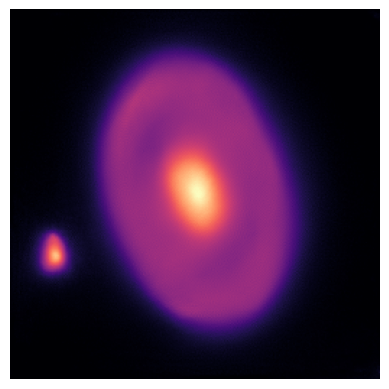

In [9]:
from astropy.visualization import ImageNormalize, AsinhStretch
norm = True
save = False
plt.style.use("default")
n_images = samples.shape[0]
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch(a=0.05))
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((link_function(samples[k])).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"/home/noedia/projects/def-lplevass/noedia/bayesian_imaging_radio/images/HTLup_pad{npix}norm.pdf"
        norm = ImageNormalize((samples/samples.max()).cpu().numpy(), vmin = 0, stretch = AsinhStretch(a=0.05))
    else: 
        save_path = f"/home/noedia/projects/def-lplevass/noedia/bayesian_imaging_radio/images/HTLup_pad{img_size}nonorm.pdf"
        norm = None
    plt.imshow((samples[0]/samples[0].max()).squeeze().cpu(), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

In [13]:
y

tensor([319.8348, 306.3285, 318.1366,  ...,  -1.2858,  -2.1128,  -7.0737],
       device='cuda:0', dtype=torch.float64)

In [ ]:
def model_no_pad(x):
    sampling_function, B, C, pad= model_parameters

    # TODO: ADD OPTION FOR BATCHED INPUT (in order to forward model multiple    
    x_padded = noise_padding(x.squeeze(), pad = pad, sigma = sigma(t, score_model))
    x_padded = link_function(x_padded, B=B, C=C)
    vis_sampled = ft(ftshift(x_padded)).squeeze()[sampling_function] # some troublesome bug makes the squeeze needed here
    y_hat = complex_to_real(vis_sampled)
    return y_hat

In [18]:
y_hat = model(t = torch.zeros(size = (1,)).to(device),x = samples, score_model = score_model, model_parameters = model_params)
y_hat

tensor([316.7818, 316.2704, 314.7421,  ...,  -3.9911,  -2.8414,  -1.5980],
       device='cuda:0')

torch.Size([174928])

In [19]:
res = (y - y_hat) / sigma_y

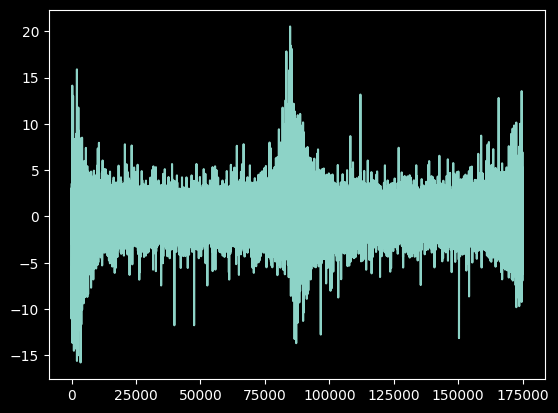

In [27]:
plt.plot(res.cpu()) 

In [23]:
S_shift.shape

torch.Size([4096, 4096])

In [82]:
def noise_padding(x, pad, sigma):
    H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad)) 
    # Create a mask for padding region
    mask = torch.ones_like(out)
    mask[pad:pad + H, pad:pad+W] = 0.
    # Noise pad around the model
    z = torch.randn_like(out) * sigma
    out = out + z * mask
    return out

def sigma(t):
    return score_model.sde.sigma(t)

def mu(t):
    return score_model.sde.marginal_prob_scalars(t)[0]

def model(t, x, score_model, model_parameters): 
    """Apply a physical model A to a ground-truth x.

    Args:
        t (torch.Tensor): temperature in the sampling procedure of diffusion models.
        x (torch.Tensor): ground-truth 
        score_model (torch.Tensor): trained score-based model (= the score of a prior)
        model_parameters (Tuple): list of parameters for the model (sampling_function, B, C)
          - index 0: sampling function (mask selecting the measured visibilities in Fourier space, must have a shape (H, W) where H and W are the height
            and width of the padded image respectively)
          - index 1 and index 2: B and C, the link_function parameters (see function link_function)

    Returns:
        y_hat (torch.Tensor): 
    """

    sampling_function, B, C, pad= model_parameters

    # TODO: ADD OPTION FOR BATCHED INPUT (in order to forward model multiple    
    x_padded = noise_padding(x.squeeze(), pad = pad, sigma = sigma(t, score_model))
    vis_sampled = ft(shift(x_padded)).squeeze()[sampling_function] # some troublesome bug makes the squeeze needed here
    
    # vis_sampled = vis_sampled.reshape(num_vis,)
    y_hat = complex_to_real(vis_sampled)
    return y_hat

B= 1
C = 0
model_parameters = (S_shift, B, C, pad)
k = torch.randn([1, 1, img_size, img_size], dtype = torch.float32).to(device) 
t = torch.ones([1]).to(device)

In [83]:
from torch.func import vmap, grad
import sys
sys.path.append("../src/inference")
from posterior_sampling import sigma, mu

# Diagonal of Gamma = AA^T (in real representation of a complex matrix)
Gamma_diag = torch.ones(size = (len(y), )).to(device)/2
Gamma_diag[0] = 1 

def log_likelihood(t, x, y, sigma_y, forward_model, score_model, model_parameters):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = forward_model(t, x, score_model, model_parameters)
    Gamma_diag = torch.ones_like(y, device = y.device)/2
    Gamma_diag[0] = 1 

    var = sigma(t, score_model) **2 * Gamma_diag + mu(t, score_model)**2 * sigma_y**2 ## sigma(t) ** 2 * AA^T + sigma_y ** 2
    res = (mu(t, score_model) * y - y_hat) ** 2 / var
    log_prob = -0.5 * torch.sum(res)
    return log_prob

def score_likelihood(t, x, y, sigma_y, forward_model, score_model, model_parameters):
    return vmap(grad(lambda x, t: log_likelihood(t, x, y, sigma_y, forward_model, score_model, model_parameters)), randomness = "different")(x, t)

#torch.manual_seed(0)
def score_posterior(t, x): 
    return score_model.score(t, x) + score_likelihood(t, x, y, sigma_y, ) 

model_params = (S_shift, B, C, pad)
k = torch.randn([1, 1, img_size, img_size]).to(device) 
t = torch.ones([1,]).to(device)

print((torch.sum(score_likelihood(t, k, y, sigma_y, model, score_model, model_params)**2))**0.5)
# print(score_posterior(t, k))

tensor(142.8551, device='cuda:0')


In [80]:
from posterior_sampling import euler_sampler

samples = euler_sampler(
    y = y,
    sigma_y = sigma_y, 
    forward_model = model, 
    score_model = score_model,
    score_likelihood = score_likelihood, 
    model_parameters = model_params, 
    num_samples = 1, 
    num_steps = 4000, 
    tweedie = False, 
    keep_chain = False, 
    debug_mode = False, 
    img_size = (256, 256)
)


t = 0.00 | scale ~ 3.63e+01 | sigma(t) = 2.84e-03 | mu(t) = 1.00e+00: 100%|██████████| 3999/3999 [05:20<00:00, 12.47it/s]


False


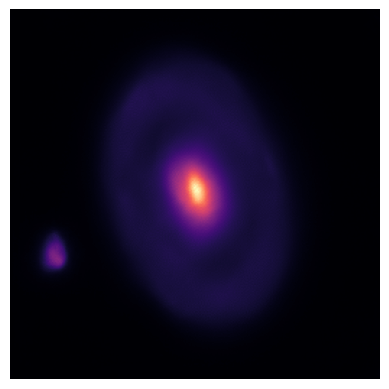

In [81]:
norm = False
save = False
plt.style.use("default")
n_images = samples.shape[0]
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch(a=0.8))
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((link_function(samples[k])).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"/home/noedia/projects/def-lplevass/noedia/bayesian_imaging_radio/images/HTLup_pad{npix}norm.pdf"
        norm = ImageNormalize((samples/samples.max()).cpu().numpy(), vmin = 0, stretch = AsinhStretch(a=0.9))
    else: 
        save_path = f"/home/noedia/projects/def-lplevass/noedia/bayesian_imaging_radio/images/HTLup_pad{img_size}nonorm.pdf"
        norm = None
    plt.imshow((samples[0]/samples[0].max()).squeeze().cpu(), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

Doing tests with new code with VP Skirt with old HTLuP gridded.  